In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import ClusteringEvaluator

In [2]:
spark=SparkSession.builder.appName("CustomerSegmentation") \
.config ("spark.sql.shuffle.partitions", "16") \
.config("spark.driver.maxResultSize","4g") \
.config ("spark.sql.execution.arrow.pyspark.enabled", "true") \
.config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
.config("spark.driver.memory", "4g") \
.config("spark.executor.cores", "4") \
.getOrCreate()

spark.sparkContext.setLogLevel("WARN")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/09/02 20:08:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/09/02 20:08:33 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/09/02 20:08:33 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [3]:
df = spark.read.csv("ecomerce.csv", header=True)

In [4]:
df.show()

+--------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|          event_time|event_type|product_id|        category_id|       category_code|   brand|  price|  user_id|        user_session|
+--------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|2019-10-01 00:00:...|      view|  44600062|2103807459595387724|                null|shiseido|  35.79|541312140|72d76fde-8bb3-4e0...|
|2019-10-01 00:00:...|      view|   3900821|2053013552326770905|appliances.enviro...|    aqua|  33.20|554748717|9333dfbd-b87a-470...|
|2019-10-01 00:00:...|      view|  17200506|2053013559792632471|furniture.living_...|    null| 543.10|519107250|566511c2-e2e3-422...|
|2019-10-01 00:00:...|      view|   1307067|2053013558920217191|  computers.notebook|  lenovo| 251.74|550050854|7c90fc70-0e80-459...|
|2019-10-01 00:00:...|      view|   1004237|205301355563188265

In [5]:
df = df.withColumn("year", year("event_time"))
df = df.withColumn("month", month("event_time"))
df = df.withColumn("day", dayofmonth("event_time"))
df = df.withColumn("day_of_week", dayofweek("event_time"))
df = df.withColumn("hour", hour("event_time"))

In [6]:
# User Behaviour Features:
user_behavior_features = df.groupBy("user_id").agg(
    count("event_type").alias("total_events"),
    count("product_id").alias("total_products_viewed"),
)

In [7]:
user_behavior_features.show()

+---------+------------+---------------------+
|  user_id|total_events|total_products_viewed|
+---------+------------+---------------------+
|519107250|          21|                   21|
|519528062|           8|                    8|
|525734504|         158|                  158|
|543427258|           3|                    3|
|531646433|          47|                   47|
|515755304|           8|                    8|
|552552067|          30|                   30|
|522806189|          21|                   21|
|518471395|          55|                   55|
|515547943|          17|                   17|
|519829701|           8|                    8|
|519194796|          29|                   29|
|520775875|          39|                   39|
|513173999|          11|                   11|
|537858238|           1|                    1|
|555448105|          18|                   18|
|554255295|           6|                    6|
|554935393|           9|                    9|
|545196189|  

In [8]:
# Extract top-level category
df = df.withColumn("category", split("category_code", "\.")[0])  

In [9]:
df.show()

+--------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+----+-----+---+-----------+----+-----------+
|          event_time|event_type|product_id|        category_id|       category_code|   brand|  price|  user_id|        user_session|year|month|day|day_of_week|hour|   category|
+--------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+----+-----+---+-----------+----+-----------+
|2019-10-01 00:00:...|      view|  44600062|2103807459595387724|                null|shiseido|  35.79|541312140|72d76fde-8bb3-4e0...|2019|   10|  1|          3|   5|       null|
|2019-10-01 00:00:...|      view|   3900821|2053013552326770905|appliances.enviro...|    aqua|  33.20|554748717|9333dfbd-b87a-470...|2019|   10|  1|          3|   5| appliances|
|2019-10-01 00:00:...|      view|  17200506|2053013559792632471|furniture.living_...|    null| 543.10|51910725

In [10]:
#null values
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+----+-----+---+-----------+----+--------+
|event_time|event_type|product_id|category_id|category_code|  brand|price|user_id|user_session|year|month|day|day_of_week|hour|category|
+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+----+-----+---+-----------+----+--------+
|         0|         0|         0|          0|     13515609|6113008|    0|      0|           2|   0|    0|  0|          0|   0|13515609|
+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+----+-----+---+-----------+----+--------+



In [11]:
df = df.na.drop(subset=["brand", "category"])


In [12]:
#null values
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+----------+----------+----------+-----------+-------------+-----+-----+-------+------------+----+-----+---+-----------+----+--------+
|event_time|event_type|product_id|category_id|category_code|brand|price|user_id|user_session|year|month|day|day_of_week|hour|category|
+----------+----------+----------+-----------+-------------+-----+-----+-------+------------+----+-----+---+-----------+----+--------+
|         0|         0|         0|          0|            0|    0|    0|      0|           2|   0|    0|  0|          0|   0|       0|
+----------+----------+----------+-----------+-------------+-----+-----+-------+------------+----+-----+---+-----------+----+--------+



In [13]:
df_features = df.groupBy("user_id").agg(
    avg("price").alias("avg_price"),
    sum("price").alias("total_spent"),
#     count("event_type").alias("total_events"),
#     count("product_id").alias("total_products_viewed"),
)

In [14]:
df_features = df_features.orderBy(col("total_spent").desc())
df_features = df_features.limit(500)
df_features.show()

+---------+------------------+------------------+
|  user_id|         avg_price|       total_spent|
+---------+------------------+------------------+
|563459593|1022.3776461538464|1993636.4100000004|
|512365995| 375.5269006289307|1492719.4299999997|
|561163588|1005.2567728531858|1451590.7800000003|
|545925192| 913.4229941434852|1247735.8100000008|
|512845454| 820.0875062761506|         980004.57|
|519267944|1432.4160117302054| 976907.7200000001|
|513900355| 888.3164456721917| 964711.6600000001|
|513117637|1337.4143567251465| 914791.4200000003|
|518692140| 905.2454273944386| 878993.3099999998|
|515384420|1721.9940000000001|         817947.15|
|516253278|  614.900165413534| 817817.2200000001|
|540323874|1002.1434362934361| 778665.4499999998|
|513185778|  951.370233128834| 775366.7399999998|
|545614761|  839.036499442587| 752615.7400000006|
|512475445|119.15782723812677| 720070.7500000001|
|515565608| 561.4275078369907| 716381.5000000001|
|517403657|1144.9083333333328| 714422.7999999997|


In [16]:
feature_columns = ["avg_price", "total_spent"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_features = assembler.transform(df_features)

In [17]:
k = 5  
kmeans = KMeans(k=k, seed=1)
model = kmeans.fit(df_features)

23/09/02 20:10:21 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [18]:
# Add cluster labels to the DataFrame
df_features = model.transform(df_features)

In [19]:
# View the results, including cluster labels
df_features.select("user_id", "features", "prediction").show()

+---------+--------------------+----------+
|  user_id|            features|prediction|
+---------+--------------------+----------+
|563459593|[1022.37764615384...|         1|
|512365995|[375.526900628930...|         1|
|561163588|[1005.25677285318...|         1|
|545925192|[913.422994143485...|         1|
|512845454|[820.087506276150...|         4|
|519267944|[1432.41601173020...|         4|
|513900355|[888.316445672191...|         4|
|513117637|[1337.41435672514...|         4|
|518692140|[905.245427394438...|         4|
|515384420|[1721.99400000000...|         4|
|516253278|[614.900165413534...|         4|
|540323874|[1002.14343629343...|         4|
|513185778|[951.370233128834...|         4|
|545614761|[839.036499442587...|         4|
|512475445|[119.157827238126...|         2|
|515565608|[561.427507836990...|         2|
|517403657|[1144.90833333333...|         2|
|512707659|[1080.47855182926...|         2|
|530834332|[1031.68183406113...|         2|
|553006057|[1558.86257709251...|

In [20]:
# Silhouette Score
evaluator = ClusteringEvaluator()
silhouette_score = evaluator.evaluate(df_features)
print(f"Silhouette Score: {silhouette_score}")

Silhouette Score: 0.8091355292540965


In [21]:
# Extract cluster centers
cluster_centers = model.clusterCenters()

# Convert the DataFrame to Pandas for plotting
df_pd = df_features.select("features", "prediction").toPandas()

/opt/homebrew/Caskroom/miniconda/base/envs/spark/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:117: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


In [22]:
df_pd

,features,prediction
0,"[1022.3776461538464, 1993636.4100000004]",1
1,"[375.5269006289307, 1492719.4299999997]",1
2,"[1005.2567728531858, 1451590.7800000003]",1
3,"[913.4229941434852, 1247735.8100000008]",1
4,"[820.0875062761506, 980004.57]",4
...,...,...
495,"[869.9410424710425, 225314.73]",0
496,"[575.0435549872122, 224842.02999999997]",0
497,"[614.2961202185793, 224832.38]",0
498,"[423.6927169811321, 224557.14]",0


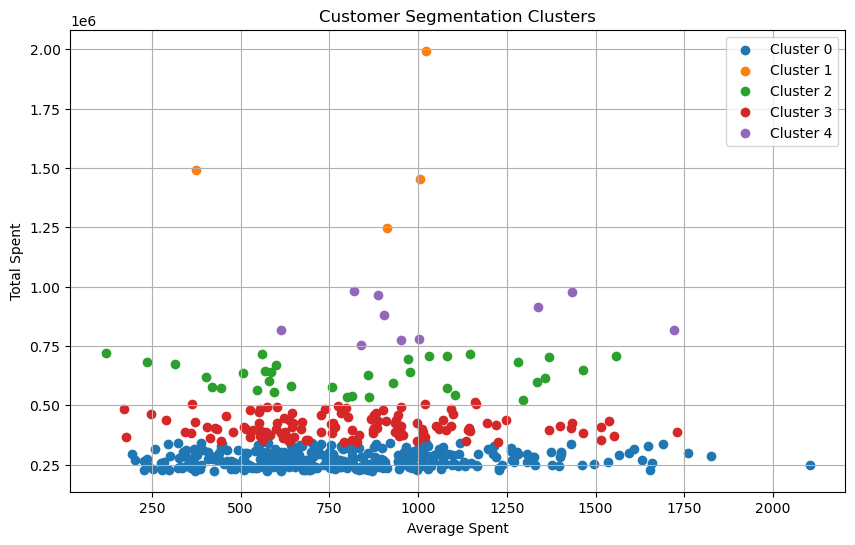

In [24]:
plt.figure(figsize=(10, 6))
for cluster in range(k):
    cluster_data = df_pd[df_pd["prediction"] == cluster]
    plt.scatter(cluster_data["features"].apply(lambda x: x[0]), cluster_data["features"].apply(lambda x: x[1]), label=f"Cluster {cluster}")

plt.title("Customer Segmentation Clusters")
plt.xlabel("Average Spent")
plt.ylabel("Total Spent")
plt.legend()
plt.grid(True)
plt.show()